# <div align='center'>Support Vector Machine</div>

<div align='left'>Support vector machines, also known as SVM is a supervised learning algorithm which can be used for classification and regression problems. Here the idea is to find the best <b>Hyperplane</b> that separates the two classes[ie in the case of Binary classification]. By best what we mean here is the hyperplane that results in the largest margin between the two classes. The data points that line on the margins are called support vectors.</div>

<img src="Images/SVM.JPG" />

<img src="Images/HLoss.JPG">

##  Method-1 : Soft-margin SVM using SGD

In [1]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
from matplotlib.lines import Line2D

Weights : [0.52373731 0.21020312] 
 Bias : 0.477400000000003


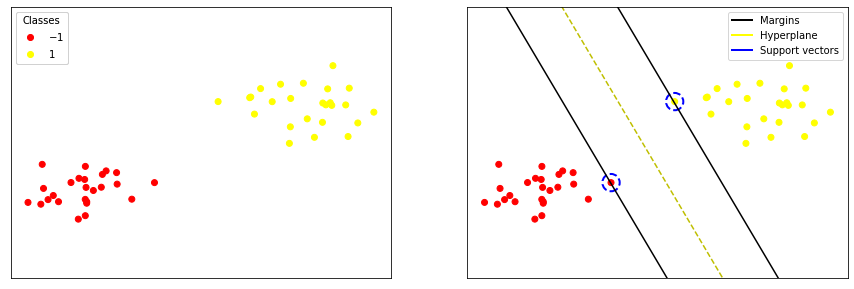

In [2]:
class SVM_SGD:

    def __init__(self, learning_rate=0.0001, eta=14, n_iters=1000):
        self.lr = learning_rate
        self.eta = eta
        self.n_iters = n_iters
        self.w = None
        
        self.b = None


    def fit(self, X, y):
        
        n_samples, n_features = X.shape
        y_ = y
        
        self.w = np.zeros(n_features)
        self.b = 0

        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y_[idx] * (np.dot(x_i, self.w) + self.b) >= 1
                if condition:
                    self.w -= self.lr*self.w
                else:
                    self.w -= self.lr * (self.w - self.eta*np.dot(x_i, y_[idx]))
                    self.b += self.lr *self.eta * y_[idx]


    def predict(self, X):
        approx = np.dot(X, self.w) + self.b
        return np.sign(approx)
    

X, y =  datasets.make_blobs(n_samples=50, n_features=2, centers=2, cluster_std=1.05, random_state=40)
y = np.where(y == 0, -1, 1)

clf = SVM_SGD()
clf.fit(X, y)

print("Weights :",clf.w,'\n',"Bias :", clf.b)

def visualize_svm():
    
    def get_hyperplane_value(x, w, b, offset):
        return (-w[0] * x - b + offset) / w[1]

    fig, ax = plt.subplots(1, 2,figsize=(15,5))
    s_plot=ax[0].scatter(X[:,0], X[:,1], marker='o',c=y,cmap='autumn')
    legends = ax[0].legend(*s_plot.legend_elements(),loc="upper left", title="Classes")
    x1_min = np.amin(X[:,1])
    x1_max = np.amax(X[:,1])
    ax[0].set_ylim([x1_min-3,x1_max+3])
    ax[0].add_artist(legends)
    ax[0].set_xticks([])
    ax[0].set_yticks([])

    x0_1 = np.amin(X[:,0])
    x0_2 = np.amax(X[:,0])

    x1_1 = get_hyperplane_value(x0_1, clf.w, clf.b, 0)
    x1_2 = get_hyperplane_value(x0_2, clf.w, clf.b, 0)

    x1_1_m = get_hyperplane_value(x0_1, clf.w, clf.b, -1)
    x1_2_m = get_hyperplane_value(x0_2, clf.w, clf.b, -1)

    x1_1_p = get_hyperplane_value(x0_1, clf.w, clf.b, 1)
    x1_2_p = get_hyperplane_value(x0_2, clf.w, clf.b, 1)
    
    s_vectors = []
    for x_ in X:
        if((np.dot(clf.w.T,x_)+clf.b+1)>=0 and (np.dot(clf.w.T,x_)+clf.b+1)<=0.1):
            s_vectors.append(x_)
        elif((np.dot(clf.w.T,x_)+clf.b-1)>=0 and (np.dot(clf.w.T,x_)+clf.b-1)<=0.1):
            s_vectors.append(x_)
    s_vectors = np.array(s_vectors)
    
    ax[1].scatter(s_vectors[:, 0],s_vectors[:, 1],s=300, linewidth=2, edgecolors='b',facecolors='none',linestyle='--')
    ax[1].scatter(X[:,0], X[:,1], marker='o',c=y,cmap='autumn')
    ax[1].plot([x0_1, x0_2],[x1_1, x1_2], 'y--')
    ax[1].plot([x0_1, x0_2],[x1_1_m, x1_2_m], 'k')
    ax[1].plot([x0_1, x0_2],[x1_1_p, x1_2_p], 'k')
    
    colors = ['black', 'yellow', 'blue']
    lines = [Line2D([0], [0], color=c, linewidth=2, linestyle='-') for c in colors]
    labels = ['Margins', 'Hyperplane', 'Support vectors']
    ax[1].legend(lines, labels,loc="upper right")

    ax[1].set_ylim([x1_min-3,x1_max+3])
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    

    plt.show()

visualize_svm()

## Method 2 : Soft-margin SVM with Kernals using CVXOPT

<img src="Images/Dprob.JPG"/>

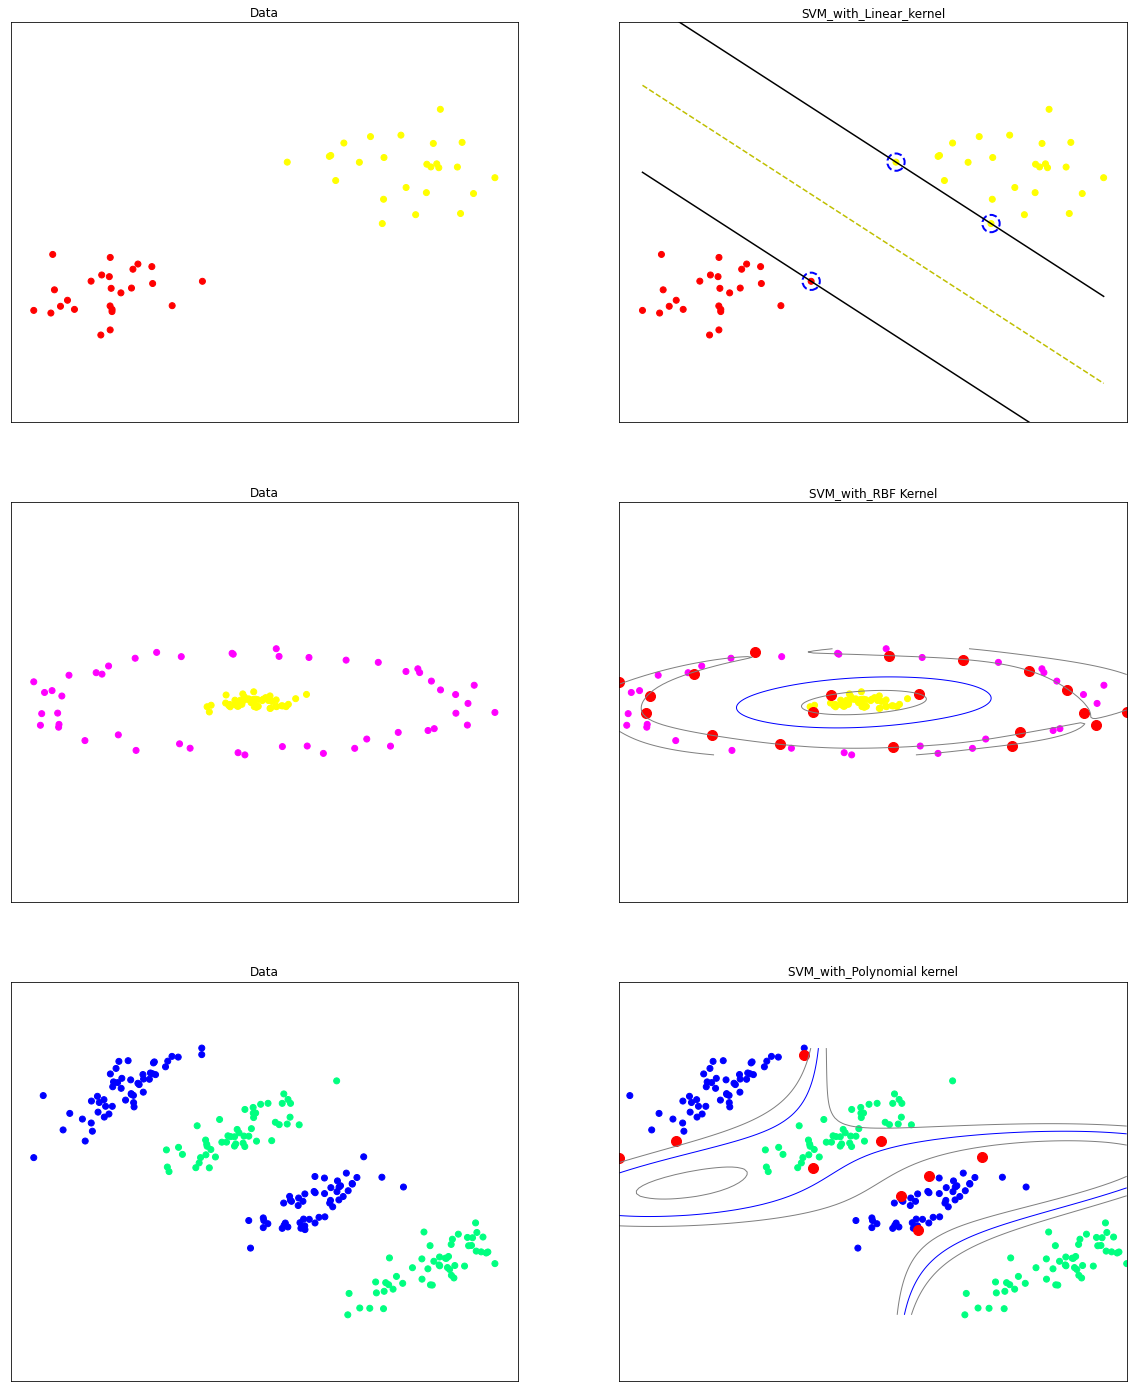

In [5]:
class Kernel_SVM:
    
    def __init__(self,k_type='Linear_kernel', gamma=None, p=None):
        
        self.k_type = k_type
        self.gamma = gamma
        self.p = p
        self.w = None
        self.b = None
        self.sv = None
        
    def Kernel(self,X1,X2):
        
        if(self.k_type == 'Linear_kernel'):
            return np.dot(X1.T,X2)
            
        elif(self.k_type == 'RBF_kernel'):
            return np.exp(-self.gamma*np.linalg.norm(X1-X2)**2)
        
        elif(self.k_type == 'Polynomial_kernel'):
            return (1 + np.dot(X1.T,X2))**self.p
        
        else:
            print("Undefined kernel found")
        
    def fit(self, X, y, C=100):
        
        n_samples, n_features = X.shape
            
        # Gram matrix
        g_mat = np.zeros((n_samples,n_samples))
        
        for i, X1 in enumerate(X):
            for j, X2 in enumerate(X):
                g_mat[i,j] = self.Kernel(X1, X2)
                
        P = matrix(np.outer(y,y) * g_mat)
        q = matrix(np.ones(n_samples) * -1)
        A = matrix(y, (1,n_samples), 'd')
        b = matrix(np.zeros(1))
        G = matrix(np.vstack((-np.eye((n_samples)), np.eye(n_samples))))
        h = matrix(np.vstack((np.zeros((n_samples,1)), np.ones((n_samples,1)) * C)))
        
        solvers.options['show_progress'] = False
        # solvers.options['abstol'] = 1e-10 [absolute accuracy (default: 1e-7)]
        # solvers.options['reltol'] = 1e-10 [relative accuracy (default: 1e-6)]
        # solvers.options['feastol'] = 1e-10 [tolerance for feasibility conditions (default: 1e-7)]
        
        # solve QP problem
        solution = solvers.qp(P, q, G, h, A, b)
        
        # Lagrange multipliers
        alphas = np.ravel(solution['x'])
        
        # Support vectors have non zero lagrange multipliers
        threshold = 1e-5
        S_vectors = (alphas > threshold).reshape(-1, )
        self.sv = X[S_vectors]
        
        self.a = alphas[S_vectors]
        self.sv_y = y[S_vectors]
        
        # Weight vector
        self.w = np.dot(X.T, alphas * y)
        
        # Bias
        self.b = np.mean(y[S_vectors] - np.dot(X[S_vectors], self.w))
        
    def project(self, X):
        if self.k_type == 'Linear_kernel':
            return np.dot(X, self.w) + self.b
        else:   
            y_predict = np.zeros(len(X))
            for i in range(len(X)):
                s = 0
                for a, sv_y, sv in zip(self.a, self.sv_y, self.sv):
                    s += a * sv_y * self.Kernel(X[i], sv)
                    y_predict[i] = s
            return y_predict + self.b 
    
    def predict(self, X):
        return np.sign(self.project(X))
    


    
# Data for RBF_Kernel
rbf_X, rbf_y = datasets.make_circles(100, factor=.09, noise=.09)
rbf_y = np.where(rbf_y == 0, -1, 1)
 
    
cov = [[1.0,0.8], [0.8, 1.0]]
X1 = np.random.multivariate_normal([-1, 2], cov, 50)
X1 = np.vstack((X1, np.random.multivariate_normal([4, -4], cov, 50)))
y1 = np.ones(len(X1))
X2 = np.random.multivariate_normal([1, -1], cov, 50)
X2 = np.vstack((X2, np.random.multivariate_normal([-4, 4], cov, 50)))
y2 = np.ones(len(X2)) * -1
    
# Data for Polynomial_Kernel
poly_X,poly_y = np.vstack((X1, X2)), np.hstack((y1, y2))

# Data for Linear_Kernel
lin_X, lin_y =  datasets.make_blobs(n_samples=50, n_features=2, centers=2, cluster_std=1.05, random_state=40)
lin_y = np.where(lin_y == 0, -1, 1)

lin_clf = Kernel_SVM('Linear_kernel')
lin_clf.fit(lin_X,lin_y)

rbf_clf = Kernel_SVM('RBF_kernel',gamma=4)
rbf_clf.fit(rbf_X,rbf_y)

poly_clf = Kernel_SVM('Polynomial_kernel',p=3)
poly_clf.fit(poly_X,poly_y)

def get_hyperplane_value(x, w, b, offset):
    return (-w[0] * x - b + offset) / w[1]


fig, ax = plt.subplots(3, 2,figsize=(20,25))

# SVM with Linear Kernel
ax[0,0].scatter(lin_X[:,0], lin_X[:,1], marker='o',c=lin_y,cmap='autumn')
ax[0,0].set_title('Data')
ax[0,1].set_title('SVM_with_Linear_kernel')
ax[0,0].set_xticks([])
ax[0,0].set_yticks([])
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])

lim1 = np.amin(lin_X[:,1])
lim2 = np.amax(lin_X[:,1])
ax[0,0].set_ylim([lim1-3,lim2+3])
ax[0,1].set_ylim([lim1-3,lim2+3])
x0_1 = np.amin(lin_X[:,0])
x0_2 = np.amax(lin_X[:,0])

x1_1 = get_hyperplane_value(x0_1, lin_clf.w, lin_clf.b, 0)
x1_2 = get_hyperplane_value(x0_2, lin_clf.w, lin_clf.b, 0)

x1_1_m = get_hyperplane_value(x0_1, lin_clf.w, lin_clf.b, -1)
x1_2_m = get_hyperplane_value(x0_2, lin_clf.w, lin_clf.b, -1)

x1_1_p = get_hyperplane_value(x0_1, lin_clf.w, lin_clf.b, 1)
x1_2_p = get_hyperplane_value(x0_2, lin_clf.w, lin_clf.b, 1)

s_vectors = np.array(lin_clf.sv)
ax[0,1].scatter(s_vectors[:, 0],s_vectors[:, 1],s=300, linewidth=2, edgecolors='b',facecolors='none',linestyle='--')
ax[0,1].scatter(lin_X[:,0], lin_X[:,1], marker='o',c=lin_y,cmap='autumn')
ax[0,1].plot([x0_1, x0_2],[x1_1, x1_2], 'y--')
ax[0,1].plot([x0_1, x0_2],[x1_1_m, x1_2_m], 'k')
ax[0,1].plot([x0_1, x0_2],[x1_1_p, x1_2_p], 'k')


# SVM with RBF Kernel
lim1 = np.amin(rbf_X[:,1])
lim2 = np.amax(rbf_X[:,1])
ax[1,0].set_ylim([lim1-3,lim2+3])
ax[1,1].set_ylim([lim1-3,lim2+3])
ax[1,0].set_title('Data')
ax[1,1].set_title('SVM_with_RBF Kernel')
ax[1,0].set_xticks([])
ax[1,0].set_yticks([])
ax[1,1].set_xticks([])
ax[1,1].set_yticks([])

ax[1,0].scatter(rbf_X[:,0], rbf_X[:,1], marker='o',c=rbf_y,cmap='spring')
ax[1,1].scatter(rbf_X[:,0], rbf_X[:,1], marker='o',c=rbf_y,cmap='spring')
ax[1,1].scatter(rbf_clf.sv[:,0], rbf_clf.sv[:,1], s=100, c="r")

x1_min, x1_max = rbf_X[:,0].min(), rbf_X[:,0].max()
x2_min, x2_max = rbf_X[:,1].min(), rbf_X[:,1].max()

X1, X2 = np.meshgrid(np.linspace(x1_min, x1_max,100), np.linspace(x2_min, x2_max,100))
X = np.array([[x1, x2] for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])
Z = rbf_clf.project(X).reshape(X1.shape)
ax[1,1].contour(X1, X2, Z, [0.0], colors='b', linewidths=1, origin='lower')
ax[1,1].contour(X1, X2, Z + 1, [0.0], colors='grey', linewidths=1, origin='lower')
ax[1,1].contour(X1, X2, Z - 1, [0.0], colors='grey', linewidths=1, origin='lower')


# SVM with Polynomial kernel
lim1 = np.amin(poly_X[:,1])
lim2 = np.amax(poly_X[:,1])
ax[2,0].set_ylim([lim1-3,lim2+3])
ax[2,1].set_ylim([lim1-3,lim2+3])
ax[2,0].set_title('Data')
ax[2,1].set_title('SVM_with_Polynomial kernel')
ax[2,0].set_xticks([])
ax[2,0].set_yticks([])
ax[2,1].set_xticks([])
ax[2,1].set_yticks([])

ax[2,0].scatter(poly_X[:,0], poly_X[:,1], marker='o',c=poly_y,cmap='winter')
ax[2,1].scatter(poly_X[:,0], poly_X[:,1], marker='o',c=poly_y,cmap='winter')
ax[2,1].scatter(poly_clf.sv[:,0], poly_clf.sv[:,1], s=100, c="r")

x1_min, x1_max = poly_X[:,0].min(), poly_X[:,0].max()
x2_min, x2_max = poly_X[:,1].min(), poly_X[:,1].max()

X1, X2 = np.meshgrid(np.linspace(x1_min, x1_max,100), np.linspace(x2_min, x2_max,100))
X = np.array([[x1, x2] for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])
Z = poly_clf.project(X).reshape(X1.shape)
ax[2,1].contour(X1, X2, Z, [0.0], colors='b', linewidths=1, origin='lower')
ax[2,1].contour(X1, X2, Z + 1, [0.0], colors='grey', linewidths=1, origin='lower')
ax[2,1].contour(X1, X2, Z - 1, [0.0], colors='grey', linewidths=1, origin='lower')